<a href="https://colab.research.google.com/github/AtrCheema/AI4Water/blob/dev/examples/paper/interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This notebook shows how to generate interpretable results using deep learning model. The deep learning model used is Dual stage LSTM model of [Qin et al., 2017](https://arxiv.org/abs/1704.02971). The dataset used is of [Camels Australia](https://essd.copernicus.org/preprints/essd-2020-228/)

In [1]:
try:
    import AI4Water
except ImportError:
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

In [2]:
import os

import tensorflow as tf
print(tf.__version__)

1.15.0


In [3]:
import numpy as np
np.__version__

'1.19.5'

In [4]:
tf.compat.v1.disable_eager_execution()

In [5]:
seed = 313
np.random.seed(seed)
tf.compat.v1.random.set_random_seed(seed)

In [6]:
from ai4water import DualAttentionModel
from ai4water.datasets import CAMELS_AUS
from ai4water.utils.utils import dateandtime_now
from ai4water.utils.utils import Jsonize
from ai4water.postprocessing import Interpret

In [7]:
dataset = CAMELS_AUS()

inputs = ['et_morton_point_SILO',
           'precipitation_AWAP',
           'tmax_AWAP',
           'tmin_AWAP',
           'vprp_AWAP',
           'rh_tmax_SILO',
           'rh_tmin_SILO'
          ]

outputs = ['streamflow_MLd']

data = dataset.fetch('401203', dynamic_features=inputs+outputs, as_dataframe=True)
data

401203
time       dynamic_features                
1957-01-01 et_morton_point_SILO    8.062837
           precipitation_AWAP      0.000000
           tmax_AWAP              20.784480
           tmin_AWAP               4.358533
           vprp_AWAP               8.142806
...                                     ...
2014-12-31 tmin_AWAP               4.522077
           vprp_AWAP               8.885449
           rh_tmax_SILO           26.714771
           rh_tmin_SILO           75.013684
           streamflow_MLd        322.791000

[169472 rows x 1 columns]

In [8]:
data = data.unstack()
data.columns = [a[1] for a in data.columns.to_flat_index()]
data.head()

,et_morton_point_SILO,precipitation_AWAP,tmax_AWAP,tmin_AWAP,vprp_AWAP,rh_tmax_SILO,rh_tmin_SILO,streamflow_MLd
time,,,,,,,,
1957-01-01,8.062837,0.0,20.784480,4.358533,8.142806,28.888577,88.900993,538.551
1957-01-02,8.519483,0.0,27.393169,4.835900,5.281136,23.516738,99.002080,531.094
1957-01-03,9.879688,0.0,28.945301,8.175408,12.920509,19.434872,77.429917,503.011
1957-01-04,6.744638,0.0,26.133843,7.017990,13.951027,42.350667,100.000000,484.512
1957-01-05,8.135359,0.0,21.450775,8.686258,12.168659,30.374862,87.634483,463.416


In [9]:
data.shape

(21184, 8)

In [10]:
(data['streamflow_MLd'].values<0.0).sum()

0

In [11]:
(data['streamflow_MLd'].values==0.0).sum()

0

In [12]:
data.isna().sum()

et_morton_point_SILO    0
precipitation_AWAP      0
tmax_AWAP               0
tmin_AWAP               0
vprp_AWAP               0
rh_tmax_SILO            0
rh_tmin_SILO            0
streamflow_MLd          0
dtype: int64

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

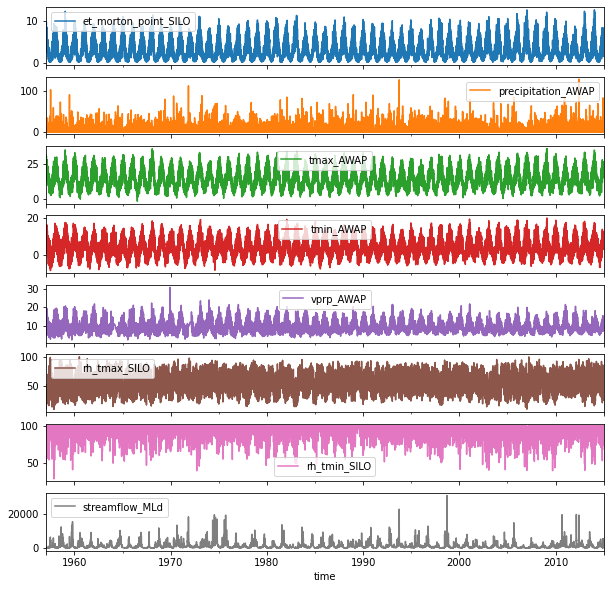

In [13]:
data.plot(subplots=True, sharex=True, figsize=(10, 10))

In [14]:
def objective_fn(return_model=False,
                 prefix=None,
                 **suggestion):

    suggestion = Jsonize(suggestion)()

    _model = DualAttentionModel(
                    input_features=inputs,
                    output_features=outputs, 
                    epochs=50,
                    forecast_step=1,
                    train_data='random',
                    lookback=int(suggestion['lookback']),
                    lr=suggestion['lr'],
                    batch_size=int(suggestion['batch_size']),
                    x_transformation=[{'method': 'robust', 'features': inputs},
                                    {'method': 'log', "replace_zeros": True, 'features': outputs}],
                    y_transformation={'method': 'robust', 'features': outputs},
                    prefix=prefix
                    )

    h = _model.fit(data=data)
    min_val_loss = float(np.min(h.history['val_loss']))
    print(f'with {suggestion} min val loss is {min_val_loss}')

    if return_model:
        return _model
    return _model


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 15, 7)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 7)            0           enc_input[0][0]                  
__________________________________________________________________________________________________
enc_first_hidden_state_1 (Input [(None, 20)]         0                                            
__________________________________________________________________________________________________
enc_first_cell_state_1 (InputLa [(None, 20)]         0                                            
______________________________________________________________________________________________

***** Training data *****
input_x shape:  (13548, 15, 7)
prev_y shape:  (13548, 14, 1)
target shape:  (13548, 1, 1)
input_x shape:  [(13548, 15, 7), (13548, 14, 1), (13548, 20), (13548, 20), (13548, 30), (13548, 30)]
target shape:  (13548, 1, 1)
***** Validation data *****
input_x shape:  (3387, 15, 7)
prev_y shape:  (3387, 14, 1)
target shape:  (3387, 1, 1)
input_x shape:  [(3387, 15, 7), (3387, 14, 1), (3387, 20), (3387, 20), (3387, 30), (3387, 30)]
target shape:  (3387, 1, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 13548 samples, validate on 3387 samples
Epoch 1/50
13548/13548 [==============================] - 49s 4ms/sample - loss: 0.3527 - nse: 0.1991 - val_loss: 0.2222 - val_nse: 0.5026
Epoch 2/50
13548/13548 [==============================] - 7s 511us/sample - loss: 0.1477 - nse: 0.6607 - val_loss: 0.0809 - val_nse: 0.8195
Epoch 3/50
13548/13548 [==============================] - 7s 520us/sample - loss: 0.0635 - nse

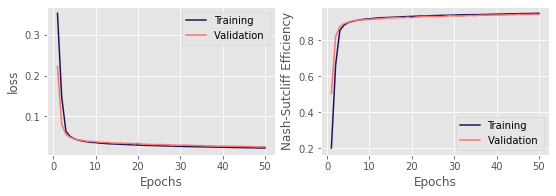

********** Successfully loaded weights from weights_049_0.02546.hdf5 file **********
with {'lookback': 15, 'lr': 0.0001, 'batch_size': 64} min val loss is 0.025458606667233704


In [15]:
model = objective_fn(return_model=True,
                     lookback=15, lr=0.0001, batch_size=64,
                    )

Making predictions on training data

***** Training data *****
input_x shape:  (13548, 15, 7)
prev_y shape:  (13548, 14, 1)
target shape:  (13548, 1, 1)
input_x shape:  [(13548, 15, 7), (13548, 14, 1), (13548, 20), (13548, 20), (13548, 30), (13548, 30)]
target shape:  (13548, 1, 1)
13548/13548 [==============================] - 2s 163us/sample


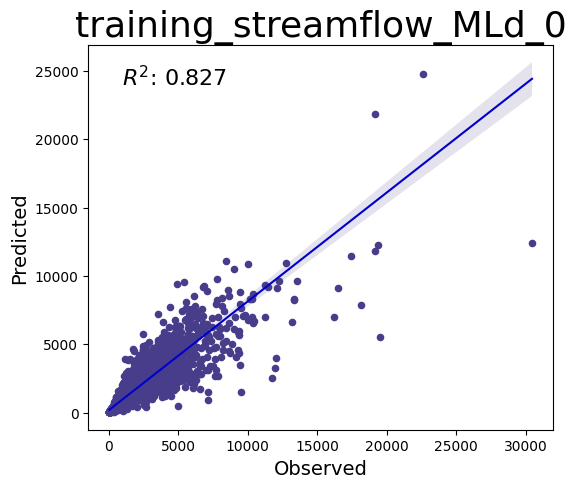

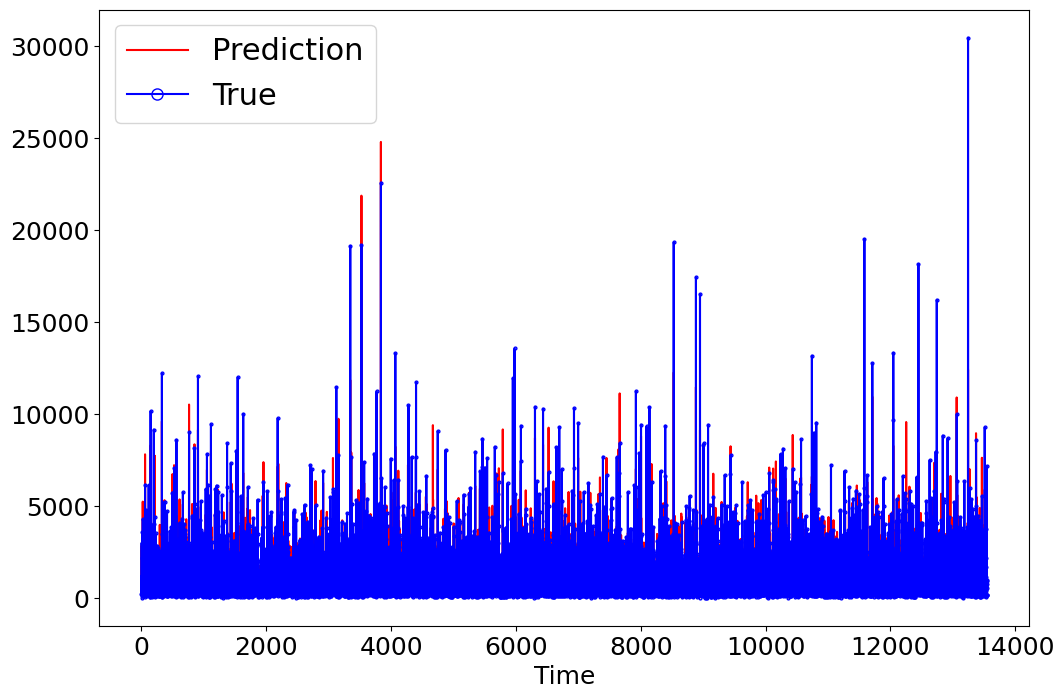

In [20]:
_ = model.predict(data='training')

Making predictions on test data

***** Test data *****
input_x shape:  (4234, 15, 7)
prev_y shape:  (4234, 14, 1)
target shape:  (4234, 1, 1)
input_x shape:  [(4234, 15, 7), (4234, 14, 1), (4234, 20), (4234, 20), (4234, 30), (4234, 30)]
target shape:  (4234, 1, 1)
4234/4234 [==============================] - 1s 156us/sample


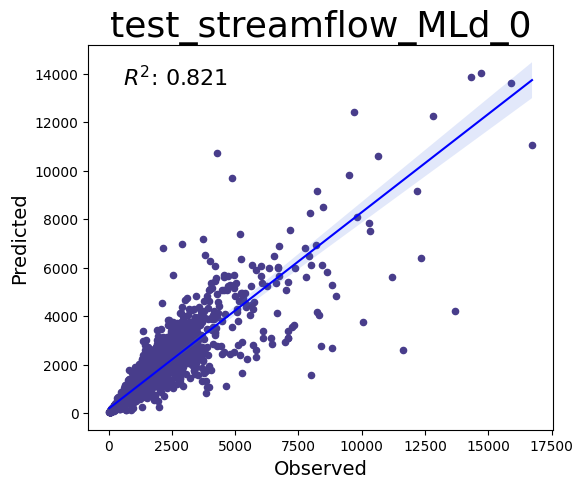

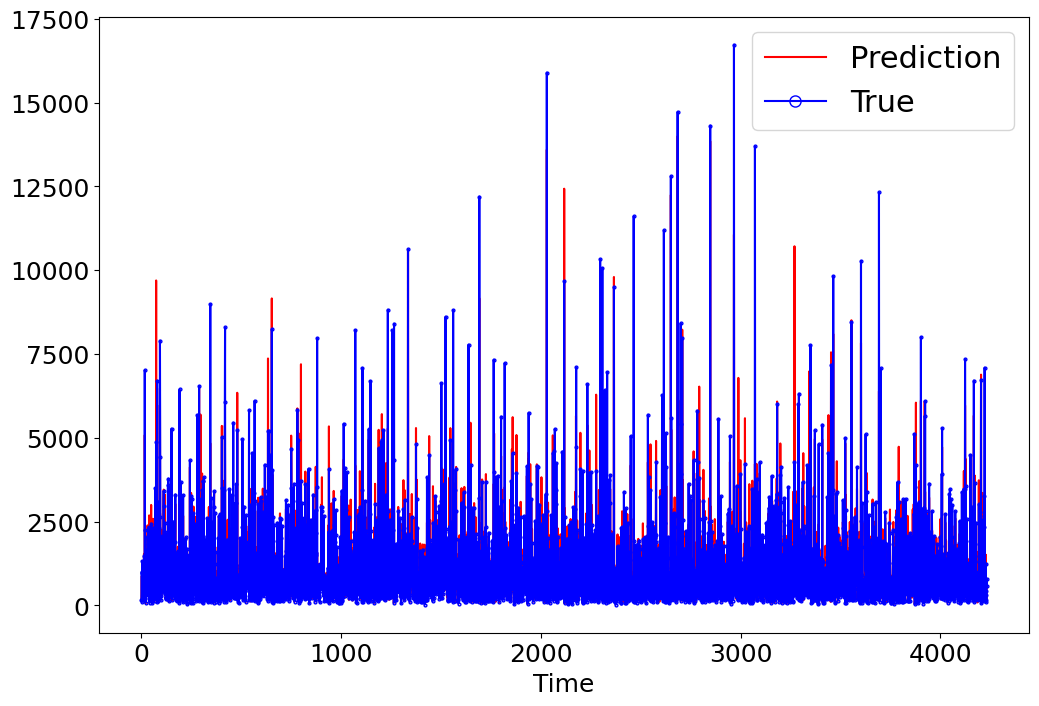

In [22]:
_ = model.predict()

Getting interpretable results

***** Training data *****
input_x shape:  (13548, 15, 7)
prev_y shape:  (13548, 14, 1)
target shape:  (13548, 1, 1)
input_x shape:  [(13548, 15, 7), (13548, 14, 1), (13548, 20), (13548, 20), (13548, 30), (13548, 30)]
target shape:  (13548, 1, 1)
13548/13548 [==============================] - 2s 172us/sample
***** Training data *****
input_x shape:  (13548, 15, 7)
prev_y shape:  (13548, 14, 1)
target shape:  (13548, 1, 1)
input_x shape:  [(13548, 15, 7), (13548, 14, 1), (13548, 20), (13548, 20), (13548, 30), (13548, 30)]
target shape:  (13548, 1, 1)
***** Training data *****
input_x shape:  (13548, 15, 7)
prev_y shape:  (13548, 14, 1)
target shape:  (13548, 1, 1)
input_x shape:  [(13548, 15, 7), (13548, 14, 1), (13548, 20), (13548, 20), (13548, 30), (13548, 30)]
target shape:  (13548, 1, 1)


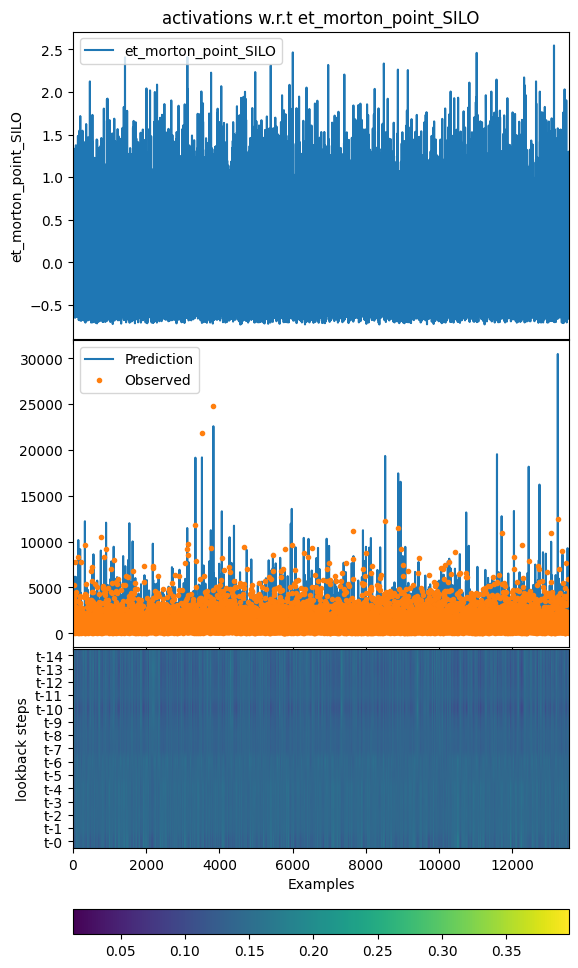

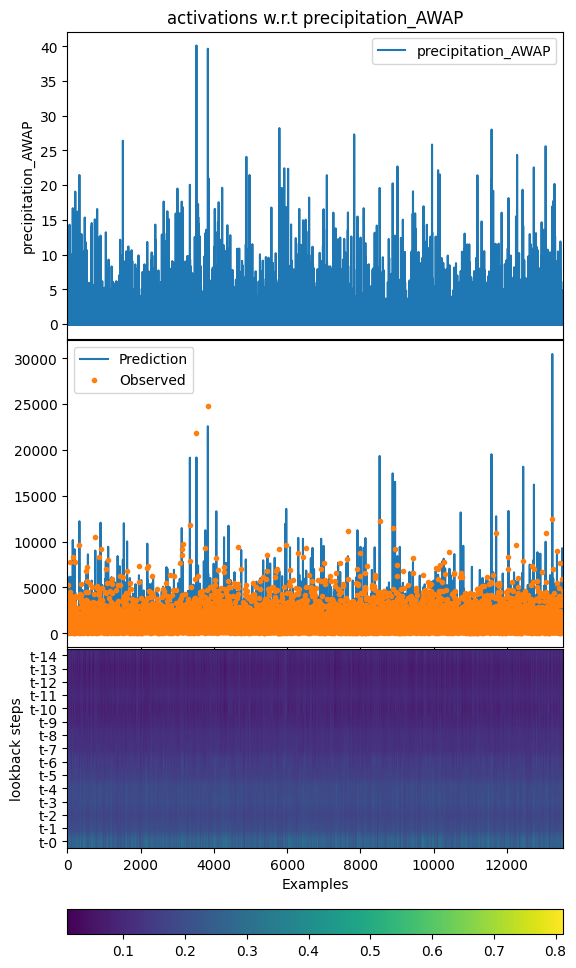

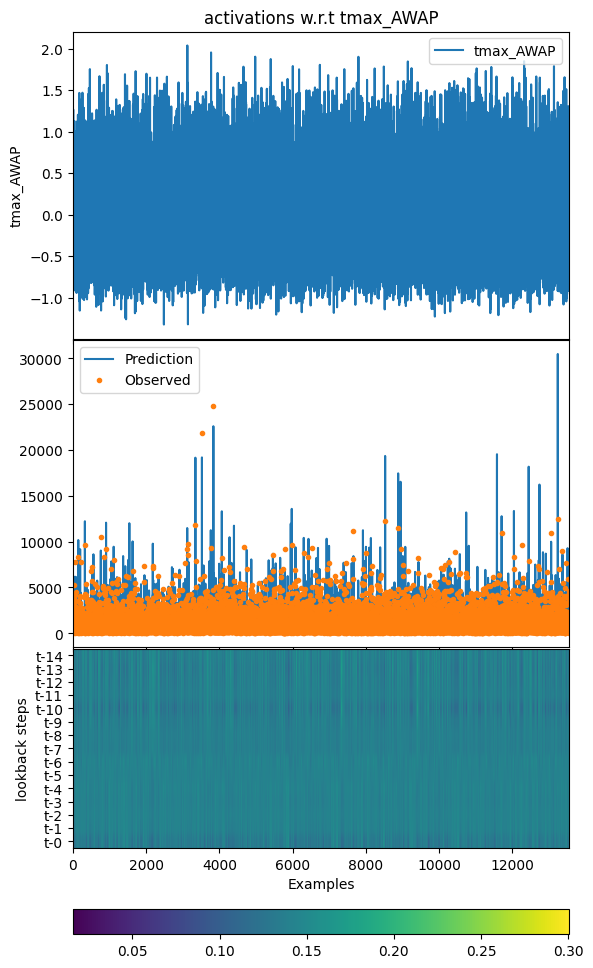

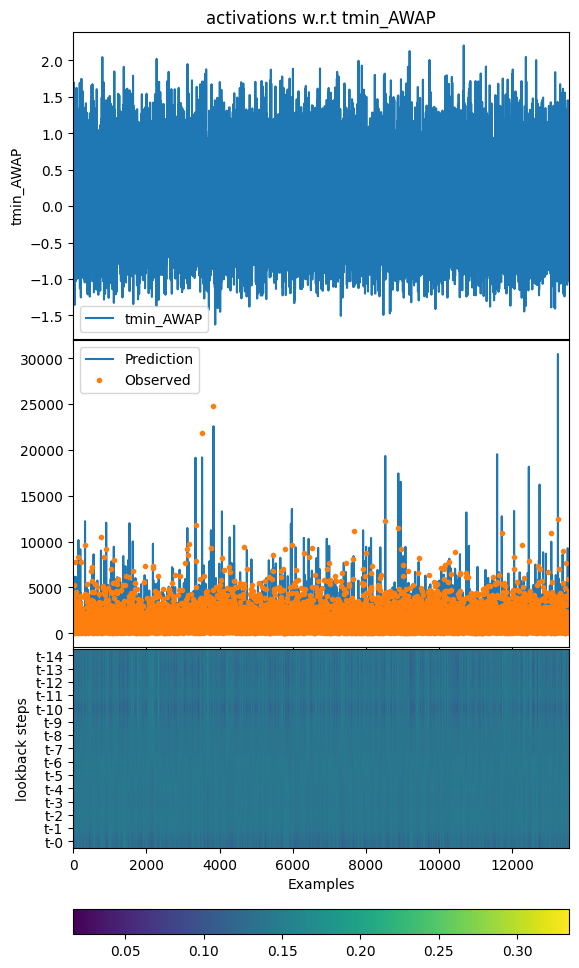

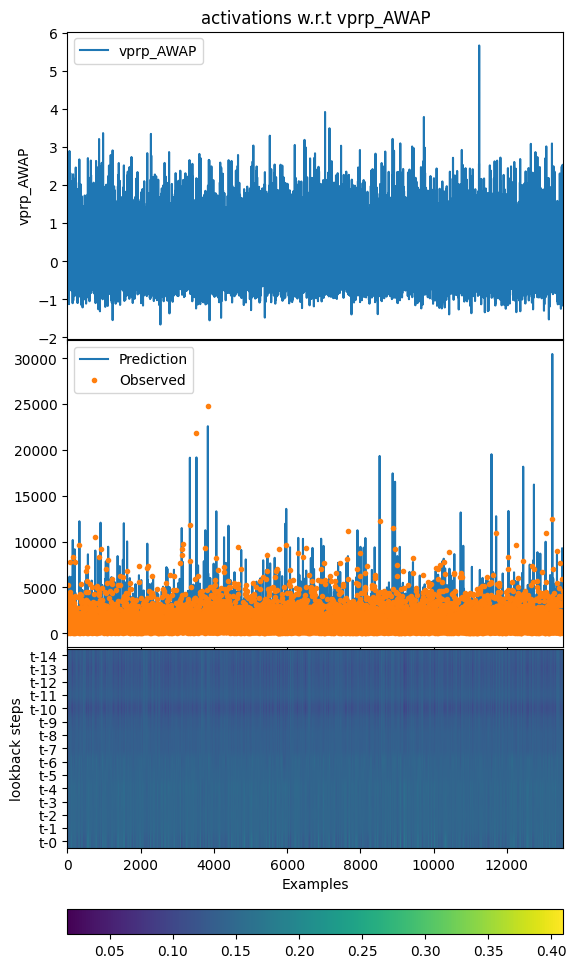

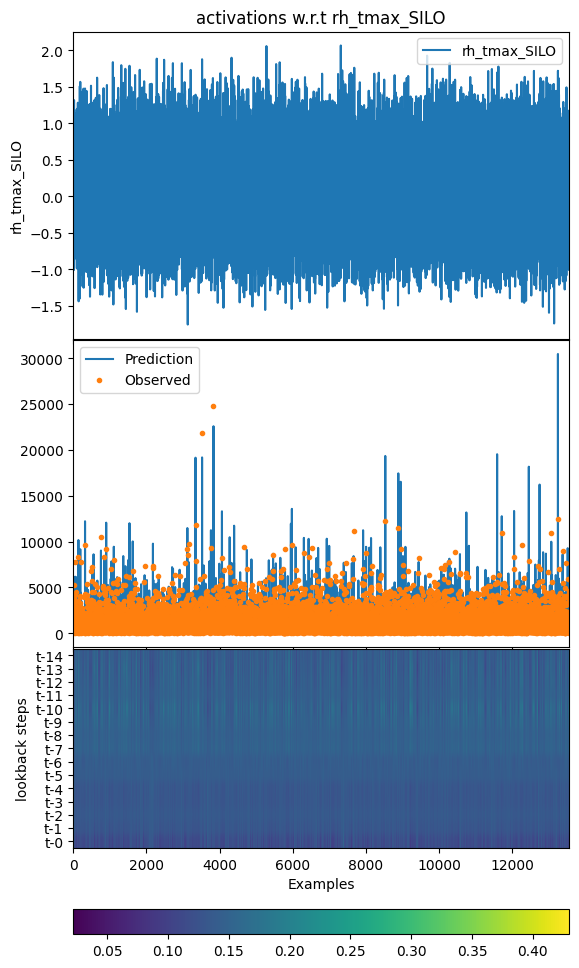

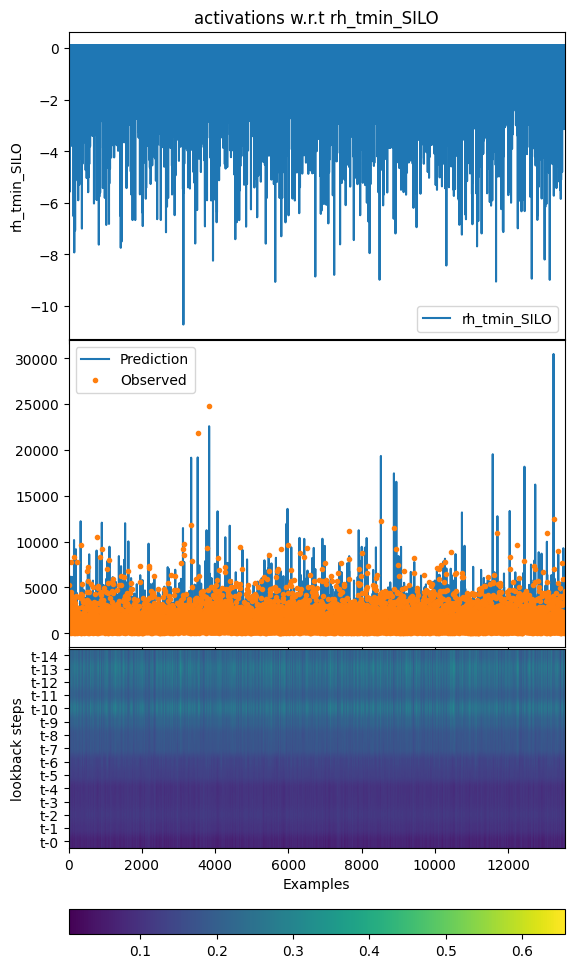

In [25]:
model.interpret(show=True)

In [19]:
print(f'All results are saved in {model.path}')

All results are saved in D:\mytools\AI4Water\examples\paper\results\20211025_140852
